In [12]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    print "Working in Windows..."
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append(r'/mnt/s/_Data/160603 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, resonator_analysis, import_data
from HeliumSurface.static_surface import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

common.configure_axes(13)

In [13]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Using the new `resonator_analysis` module

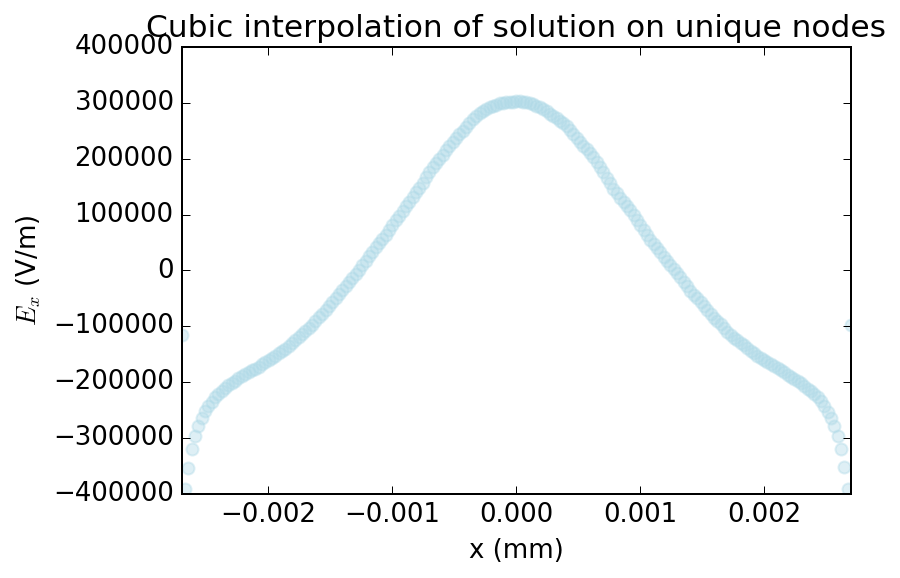

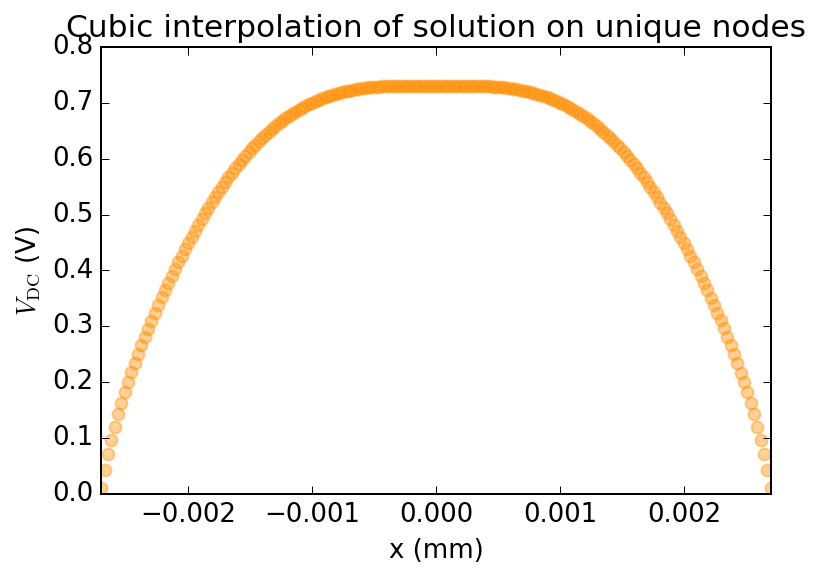

In [23]:
el = resonator_analysis.ResonatorSolver(use_FEM_data=True)

# Helium level height used for both simulation data
h = 0.78E-3
resonator_voltage = 1.00
input_power = -100

# RF E_x field from FEM simulation
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160601 - M016v5 resonator xz cut Ex.dsp'
path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160601 - M016v5 resonator xz cut Ex.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)
plt.figure(figsize=(6.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-2.7E-3, 2.7E-3, 201), 
                                                     yeval=h, clim=None, 
                                                     linestyle='None', plot_axes='xy', cmap=plt.cm.viridis, 
                                                     **common.plot_opt('lightblue', msize=6))
plt.ylabel("$E_x$ (V/m)")
ax = plt.gca()
ax.set_axis_bgcolor('none')
el.x_RF_FEM = xinterp[0]*1E-3
el.U_RF_FEM = Uinterp[0]

common.save_figure(plt.gcf(), save_path=r"/mnt/s/Gerwin/Electron on helium/iPython notebooks/Figures")

# DC curvature from FEM simulation
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160524 - M016v5 resonator xz cut.dsp'
path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160524 - M016v5 resonator xz cut.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)
plt.figure(figsize=(6.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata*resonator_voltage, 
                                                     xeval=np.linspace(-2.7E-3, 2.7E-3, 201), 
                                                     yeval=h, clim=None, 
                                                     linestyle='None', plot_axes='xy', cmap=plt.cm.viridis, 
                                                     **common.plot_opt('darkorange', msize=6))
plt.ylabel(r"$V_\mathrm{DC}$ (V)")
ax = plt.gca()
ax.set_axis_bgcolor('none')

el.x_DC_FEM = xinterp[0,:-2]*1E-3 # differentiating twice reduces the length of the potential array by 2
el.V_DC_FEM = -1/2. * np.diff(Uinterp[0], n=2)/np.diff(el.x_DC_FEM)[0]**2 # Don't forget the minus sign

common.save_figure(plt.gcf(), save_path=r"/mnt/s/Gerwin/Electron on helium/iPython notebooks/Figures")

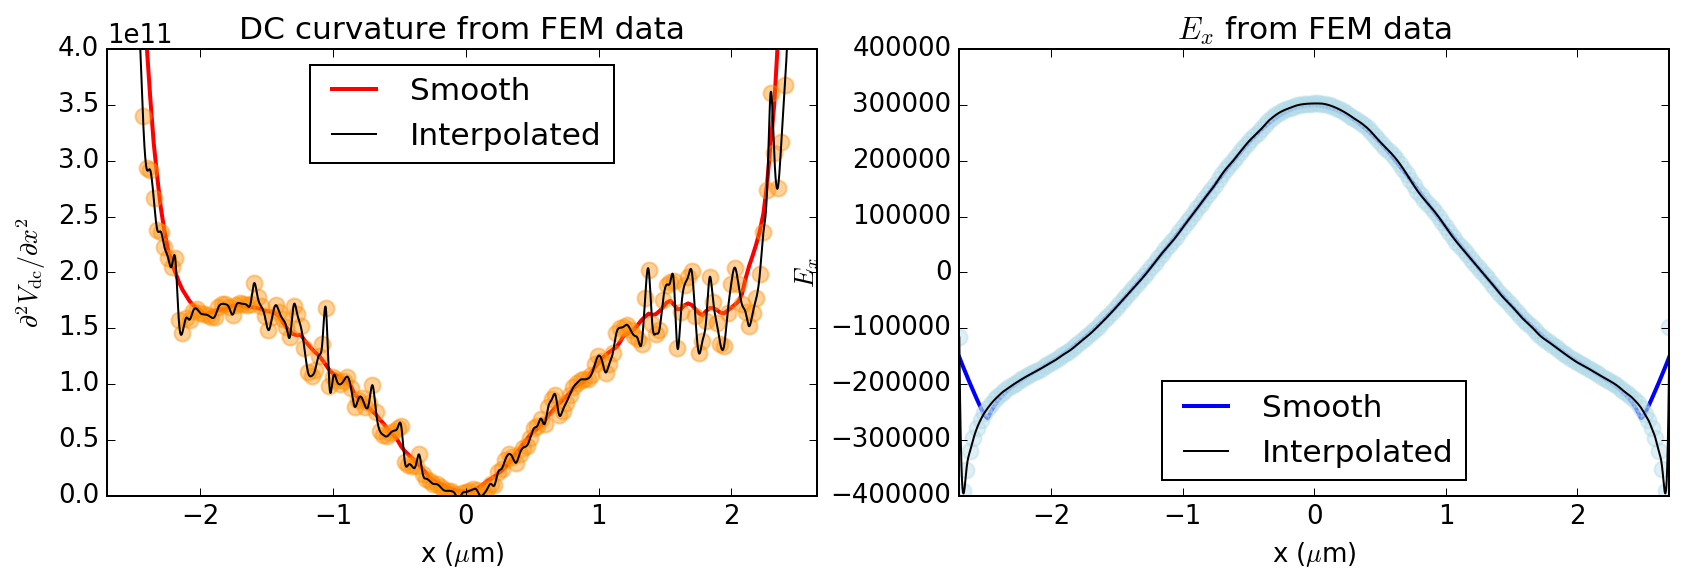

In [26]:
# Don't run this cell twice.
# Potential verification
plt.figure(figsize=(14.,4.))
common.configure_axes(13)
plt.subplot(121)
plt.plot(el.x_DC_FEM*1E6, common.moving_average(el.V_DC_FEM, 15), '-', color='red', lw=2.0, label='Smooth')
el.plot_dc_potential(None, *[None])
plt.ylim(0.0, 4E11)
ax = plt.gca()
ax.set_axis_bgcolor('none')

plt.subplot(122)
plt.plot(el.x_RF_FEM*1E6, common.moving_average(el.U_RF_FEM, 15), '-', color='blue', lw=2.0, label='Smooth')
el.plot_rf_potential(None, *[None])
ax = plt.gca()
ax.set_axis_bgcolor('none')

# We use a smooth version of the data above
el.V_DC_FEM = common.moving_average(el.V_DC_FEM, 15)
el.U_RF_FEM = common.moving_average(el.U_RF_FEM, 15)

common.save_figure(plt.gcf(), save_path=r"/mnt/s/Gerwin/Electron on helium/iPython notebooks/Figures")

In [24]:
# EOM solver
n = 500
electron_positions = np.vstack((np.zeros(n), np.linspace(-1000E-6, 1000E-6, n)))
lhs = el.setup_eom(electron_positions)
evals, evecs = el.solve_eom(lhs)

100%|██████████| 500/500 [00:00<00:00, 12901.90it/s]


Note that the actual fit domain is very sensitive in determining the electron resonance frequency...

/home/ge/anaconda3/envs/lizards/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


f = 5.921 +/- inf GHz


(5920756225.2895889, inf)

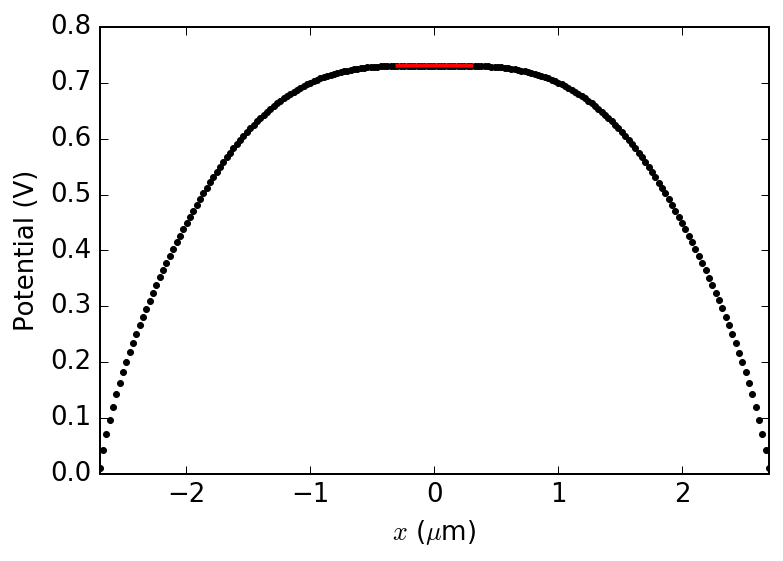

In [6]:
check = trap_analysis.TrapSolver()
fr, ferr = check.fit_electron_potential(xinterp[0]*1E3, Uinterp[0], fitdomain=(-0.3, 0.3), do_plot=True)
check.get_electron_frequency(fr, ferr)

## Eigenmodes of the system

Norm for eigenvector 1 is 1.00000000
Norm for eigenvector 2 is 1.00000000
Norm for eigenvector 3 is 1.00000000
Norm for eigenvector 4 is 1.00000000
Norm for eigenvector 5 is 1.00000000
Norm for eigenvector 6 is 1.00000000
Norm for eigenvector 7 is 1.00000000
Norm for eigenvector 8 is 1.00000000
Norm for eigenvector 9 is 1.00000000


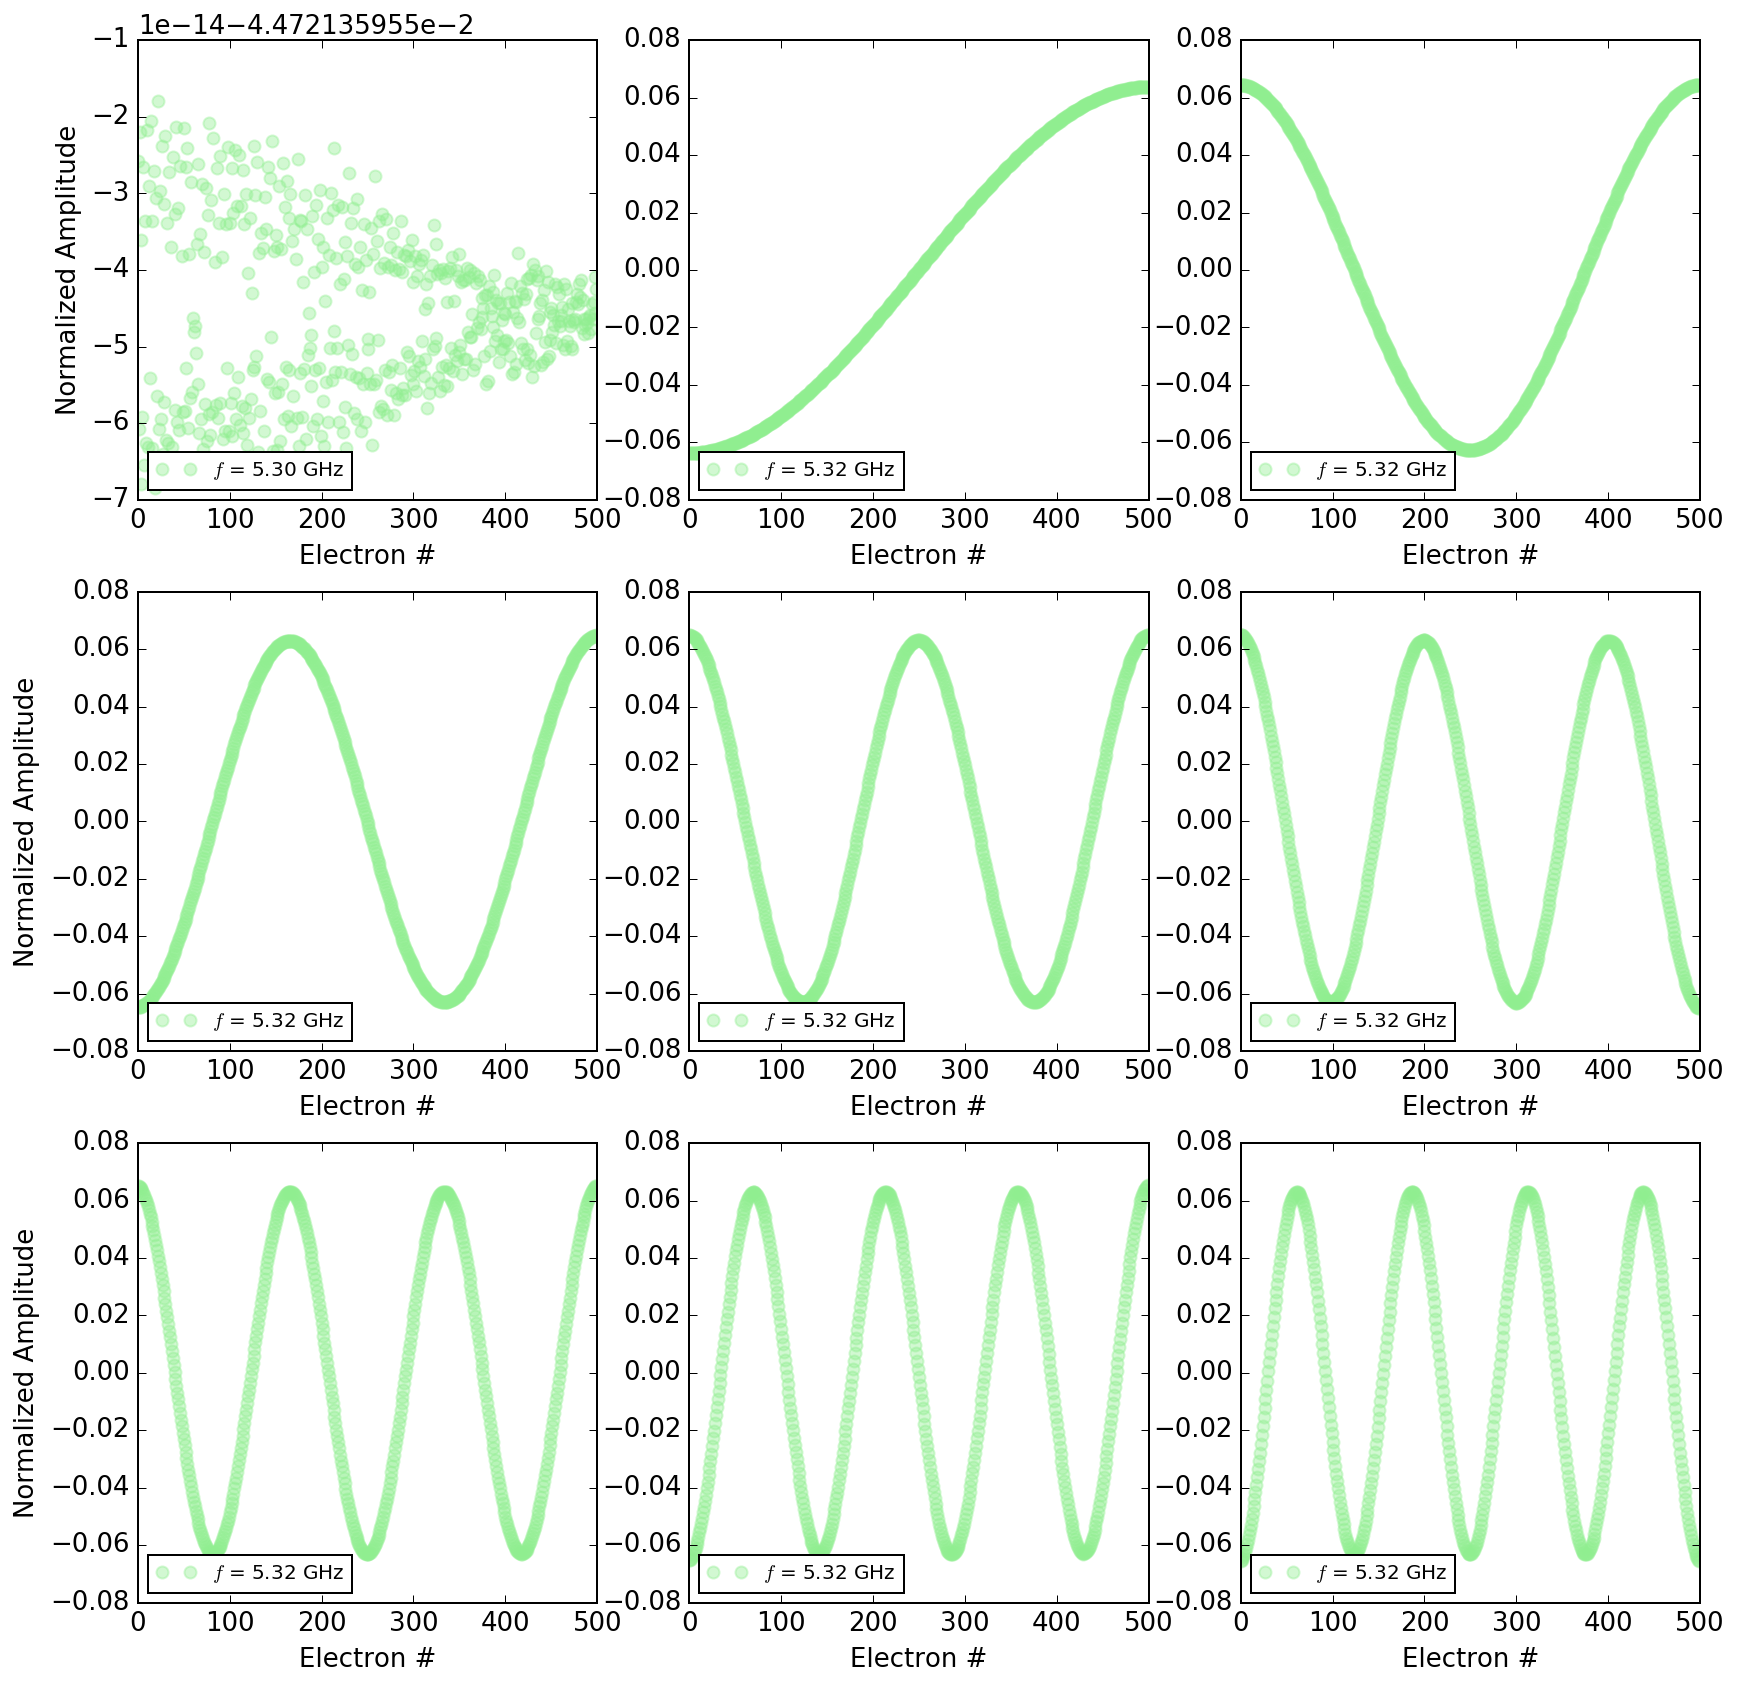

In [25]:
plt.figure(figsize=(14.,14.))
for k in range(9):
    plt.subplot("33%d"%(k+1))
    plt.plot(evecs[1:,k+1], 'o', label="$f$ = %.2f GHz"%(np.sqrt(evals[k+1])/(2*np.pi*1E9)), 
             **common.plot_opt('lightgreen', msize=6))
    plt.xlabel("Electron #")
    plt.legend(loc=3, prop={"size":10})
    ax = plt.gca()
    ax.set_axis_bgcolor('none')
    if k%3 == 0:
        plt.ylabel("Normalized Amplitude")
        
    print "Norm for eigenvector %d is %.8f"%(k+1, np.linalg.norm(evecs[1:,k+1]))
    
common.save_figure(plt.gcf(), save_path=r"/mnt/s/Gerwin/Electron on helium/iPython notebooks/Figures")

## Resonator voltage sweep

This part can take a while if you're working with large number of electrons. 1000 x 1000 usually takes ~ 1.5 s per iteration.

In [19]:
resVs = np.linspace(0.5, 1.5, 21)
normalized_V_DC = el.V_DC_FEM
f0s = list()
for idx, resV in tqdm(enumerate(resVs)):
    el.V_DC_FEM = resV*normalized_V_DC
    lhs = el.setup_eom(electron_positions)
    evals, evecs = el.solve_eom(lhs)
    f0s.append(np.sqrt(evals[0])/(2*np.pi))

# Reset it for future use
el.V_DC_FEM = normalized_V_DC

0it [00:00, ?it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
1it [00:00,  1.24it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
2it [00:01,  1.25it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
3it [00:02,  1.26it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
4it [00:03,  1.26it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
5it [00:03,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
6it [00:04,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
7it [00:05,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
8it [00:06,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
9it [00:07,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
10it [00:07,  1.26it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
11it [00:08,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
12it [00:09,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
13it [00:10,  1.26it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
14it [00:11,  1.27it/s]
  0%|          | 0/500 [00:00<?, ?it/s]
15it [00:11,  1.27it/s]
  0%|          | 0/500 [00:00<

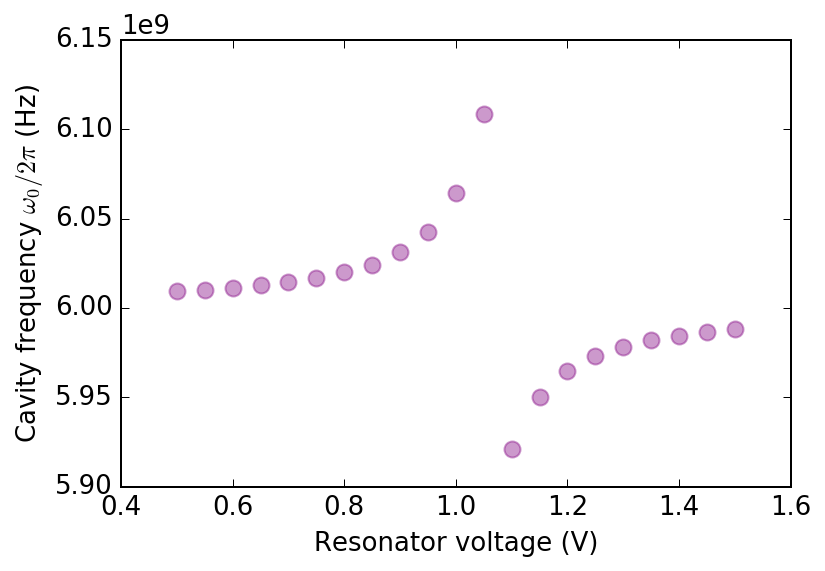

In [27]:
plt.plot(resVs, f0s, 'o', **common.plot_opt('purple'))
plt.xlabel("Resonator voltage (V)")
plt.ylabel("Cavity frequency $\omega_0/2\pi$ (Hz)")
ax = plt.gca()
ax.set_axis_bgcolor('none')
common.save_figure(plt.gcf(), save_path=r"/mnt/s/Gerwin/Electron on helium/iPython notebooks/Figures")